In [1]:
import numpy as np
from SERGIO.GRN import grn_from_human,grn_from_networkx
from SERGIO._sergio import sergio
from SERGIO.MR import mrProfile
import pandas as pd
from SERGIO.GRN._grn import GRN
from SERGIO.GRN._components import Gene, SingleInteraction


# Simulate GRN

Use regulatory network from Zhi-Ping Liu, Canglin Wu, Hongyu Miao and Hulin Wu (2015). RegNetwork: an integrated database of transcriptional and posttranscriptional regulatory networks in human and mouse. Database 2015. doi: [10.1093/database/bav095](10.1093/database/bav095)

In [2]:
grn = grn_from_human()

In [3]:

mrs = grn.get_mrs()
mr_profs = mrProfile(MR_names = mrs, n_types = 1)
mr_profs.build_rnd(range_dict={'L': [1, 2.5], 'H': [3.5, 5]})


In [30]:
grn.init(mr_profs, update_half_resp = True)
sim = sergio(grn)
%time sim.simulate(nCells = 100, noise_s = 1, safety_iter = 150, scale_iter = 10)

CPU times: user 13 s, sys: 5.01 ms, total: 13 s
Wall time: 13 s


In [6]:
expr = sim.getSimExpr()

# Use custom graph from networkx

In [8]:
import networkx as nx

In [12]:
# create a networkx.DiGraph()
G = nx.DiGraph()
G.add_edges_from([('1','2',{'weight':2}),('2','3',{'weight':-1}),('3','1',{'weight':3})])# if weight is not given, grn_from_networkx will parametrize automatically

# convert the networkx.DiGraph() to a GRN object
grn = grn_from_networkx(g= G, parametrize=False)

In [13]:
mrs = grn.get_mrs()
mr_profs = mrProfile(MR_names = mrs, n_types = 2)
mr_profs.build_rnd(range_dict={'L': [1, 2.5], 'H': [3.5, 5]})
grn.init(mr_profs, update_half_resp = True)
sim = sergio(grn)
sim.simulate(nCells = 200, noise_s = 1, safety_iter = 150, scale_iter = 10)

In [13]:
A = grn.to_networkx()

In [23]:
a = set(A.edges())
a.add(1)#note that Sergio removes cycles

## Add Technical Noise _ Steady-State Simulations

In [7]:
"""
Add outlier genes
"""
expr_O = sim.outlier_effect(expr, outlier_prob = 0.01, mean = 0.8, scale = 1)

"""
Add Library Size Effect
"""
libFactor, expr_O_L = sim.lib_size_effect(expr_O, mean = 4.6, scale = 0.4)

"""
Add Dropouts
"""
binary_ind = sim.dropout_indicator(expr_O_L, shape = 6.5, percentile = 82)
expr_O_L_D = np.multiply(binary_ind, expr_O_L)

"""
Convert to UMI count
"""
count_matrix = sim.convert_to_UMIcounts(expr_O_L_D)



# Simulate perturbation
In the following, we perturb nodes that have a successor, and we measure the effect of perturbation.

In [3]:
from SERGIO._perturbation import perturbation

select production rate for nodes perturbed with crispri and crispra. The idea is that
`basal_prod_crispri`$\ll$`basal_prod_crispra ` should be a small number, while


In [4]:
pert = perturbation(grn)
pert.init(basal_prod_crispri = 0.2,basal_prod_crispra = 7)#select production rate for nodes perturbed with crispri and crispra.

INFO:SERGIO._perturbation:Number of nodes will be perturbed is 43


In [5]:
%time pert.perturbation_all(nCells=100)
#pert.save()

CPU times: user 41.3 s, sys: 2.2 s, total: 43.5 s
Wall time: 2min 18s


Now it has been generated `pert.crispri_data`,`pert.crispra_data` and `pert.wt`, which contains perturbation and wild type information.
`pert.crispri_data` is structured as follows:
- dimension 0 describes the index target gene
- dimension 1 describe the index of genes whose expression is measured
- dimension 2 describes the index of cell

`pert.wt` is structured as follows:
- dimension 0 describe the index of genes whose expression is measured
- dimension 1 describes the index of cell

The name of gene perturbed can be found from `nodes_2perturb`, and  the gene measured from `pert.gNames_`

In [9]:
pert.crispri_data.shape,pert.wt.shape

((43, 400, 100), (400, 100))

visualise the effect of perturbation

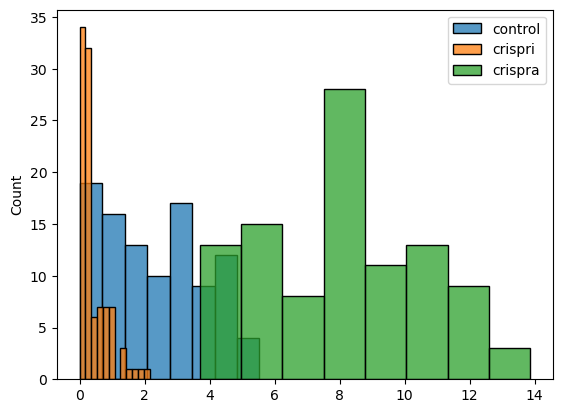

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
node_perturb = pert.nodes_2perturb[0]#take the first element for demostration, you can take any element you like
index_expr = pert.gNames_.index(node_perturb)#take the index of the node for the expression dimension
sns.histplot(pert.wt[index_expr],label = 'control')
sns.histplot(pert.crispri_data[pert.nodes_2perturb == node_perturb,index_expr][0],label = 'crispri')
sns.histplot(pert.crispra_data[pert.nodes_2perturb == node_perturb,index_expr][0],label = 'crispra')
plt.legend()

In [50]:
#to do add technical noise to perturbation object